In [1]:
import json
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from datetime import datetime,timedelta
import random
from itertools import combinations
import matplotlib.pyplot as plt
%matplotlib inline
import string
import nltk
from nltk.stem import PorterStemmer
from collections import defaultdict

In [2]:
user_index = json.load(open("../data/user_index.json",'r'))
commitment_index = json.load(open("../data/commitment_index.json",'r'))

In [3]:
max_user_id = max([int(i) for i in user_index.keys()])

In [4]:
for k,v in tqdm(user_index.items()):
    user_index[k]['date'] = datetime.strptime(v['date'], '%d %b %Y')

  0%|          | 0/655750 [00:00<?, ?it/s]

In [5]:
id_for_1_jan_2023 = 722621
for k,v in tqdm(user_index.items()):
    if int(k)<id_for_1_jan_2023 and v['date'].year == 2023:
        user_index[k]['date'] = None

  0%|          | 0/655750 [00:00<?, ?it/s]

In [6]:
key_date = user_index[str(max_user_id)]['date']
for i in tqdm(range(max_user_id,id_for_1_jan_2023,-1)):
    if str(i) in user_index.keys():
        if user_index[str(i)]['date']> key_date:
            user_index[str(i)]['date'] = None
        else:
            key_date = user_index[str(i)]['date']

  0%|          | 0/20302 [00:00<?, ?it/s]

In [7]:
last_date = user_index['1']['date']
for i in range(1, max_user_id+1):
    if str(i) in user_index.keys():
        if user_index[str(i)]['date'] == None:
            user_index[str(i)]['date'] = last_date
        else:
            last_date = user_index[str(i)]['date']

In [8]:
for k,v in tqdm(commitment_index.items()):
    commitment_index[k]['start_date'] = datetime.strptime(v['start_date'], '%B %d, %Y')
    commitment_index[k]['end_date'] = datetime.strptime(v['end_date'], '%B %d, %Y')

  0%|          | 0/397456 [00:00<?, ?it/s]

In [9]:
for k,v in tqdm(commitment_index.items()):
    if v['start_date'].year < 2007:
        deta = v['end_date'] - v['start_date']
        commitment_index[k]['start_date'] = user_index[str(v['user_id'])]['date']
        commitment_index[k]['end_date'] = commitment_index[k]['start_date'] + deta

  0%|          | 0/397456 [00:00<?, ?it/s]

Extract data

In [10]:
len(commitment_index)

397456

In [11]:
ps = PorterStemmer()

In [12]:
def preprocess_title(title):
    title = title.replace("/"," ")
    tokens = nltk.word_tokenize(title)
    tokens = [i.lower() for i in tokens]
    tokens = [i.translate(str.maketrans('', '', string.punctuation)) for i in tokens]
    tokens = [ps.stem(i) for i in tokens]
    return tokens

In [13]:
term_dict = {
    "weight":["weight","diet","fat", "pound", "kg", "calories",'kilos','pounds','kcal'],
    "eat":["eat","chocolate", "water", "food", "sugar", "softdrinks", "candy", "desserts", "veggies","gluten", "lactose", "snacking", "coffee","beverage","shakes", "caffeine"],
    "exercise":["exercise","run", "walk","race", "cycling","work-out","workout", "bicyclng","gym","km","steps", 'miles',"fitness", "yoga",'cardio','squats','deadlift',"climbing", "hike","pushup","pullup","healthy"],
    "smoking":["smoking"],
    "alcohol":['alcohol','drink','beer','wine','booze'],
    "sleep":["sleep","bed","wake",'asleep','nap'],
    "read":["read","book"],
    "study":["study","exam","diploma", "phd", "assignment", "math","gmat",'homework', 'gre', 'sat', 'school', 'learn',"thesis", "degree",'certification', "preparation","dissertation", "class", "course","english","french","spanish","java","experiments"],
    "write":["write","draft", "screenplay","scripts",'copywriting'],
    "mastrubate":["mastrubate","mastrubation","porn","masturbation",'nofap','fap','porngraphy'],
    "meditate":["meditate","journal"],
    "money":["money","finance","saving", "expense", "spending", "earn", "save",'budget','buy','invest','cash','debt'],
    "nail":["nail","hair", "brush", "floss","shower"],
    "client":["client","job","business",'network', "inbox", "emails",'career'],
    "procrastinating":["procrastinating","procrastinate","procrastination",'productive'],
    "clean":["clean","laundry", "tidy"],
    "internet":["internet", "electronics",'tv','phone',"mobile", "games"]
}

In [14]:
term_dict_n_gram = {
    "weight":['in shape'],
    "exercise":["work out", "push up", "pull up"],
    "sleep":['wake up','get up'],
    "internet":["social media"]
}

In [15]:
term_dict = {k:[ps.stem(i) for i in v] for k,v in term_dict.items()}

In [16]:
count_dict = {k:[] for k in term_dict.keys()}

term_count = {k:{i:[] for i in v} for k,v in term_dict.items()}

for k,v in term_dict_n_gram.items():
    for i in v:
        term_count[k][i] = []
        
term_count['money']['$'] = []

In [17]:
for k,v in tqdm(commitment_index.items()):
    pre_title = preprocess_title(v['title'])
    for t,rt in term_dict.items():
        for ct in rt:
            if ct in pre_title:
                count_dict[t].append(k)
                term_count[t][ct].append(k)
                
    pre_title = " ".join(pre_title)
    for t,rt in term_dict_n_gram.items():
        for ct in rt:
            if ct in pre_title:
                count_dict[t].append(k)
                term_count[t][ct].append(k)
                
    if "$" in v['title']:
        count_dict['money'].append(k)
        term_count['money']['$'].append(k)

  0%|          | 0/397456 [00:00<?, ?it/s]

In [18]:
for k,v in count_dict.items():
    count_dict[k] = list(set(v))
    
for k,v in term_count.items():
    for t,l in v.items():
        term_count[k][t] = list(set(l))

In [19]:
len(set([j for v in count_dict.values() for j in v]))

290008

In [20]:
len(set([j for v in count_dict.values() for j in v]))/len(commitment_index)

0.7296606416810918

In [21]:
# for k,v in count_dict.items():
#     print("-"*100)
#     print(k)
#     for j in random.sample(v,min(5,len(v))):
#         print(commitment_index[j]['title'])

### Overlap analysis

In [22]:
# res = list(combinations(count_dict.keys(), 2))
# total_intersection_count = 0
# for i in res:
#     intersection_count = set.intersection(*[set(count_dict[j]) for j in i])
#     total_intersection_count+=len(intersection_count)
#     if len(intersection_count)>0:
#         print("-"*50)
#         print(f"{i} {len(intersection_count)}")
#         for s in random.sample(list(intersection_count),min(5,len(intersection_count))):
#             print(commitment_index[s]['title'])

In [23]:
# total_intersection_count 

In [24]:
# res = list(combinations(count_dict.keys(), 3))
# total_intersection_count = 0
# for i in res:
#     intersection_count = set.intersection(*[set(count_dict[j]) for j in i])
#     total_intersection_count+=len(intersection_count)
#     if len(intersection_count)>0:
#         print("-"*50)
#         print(f"{i} {len(intersection_count)}")
#         for s in random.sample(list(intersection_count),min(5,len(intersection_count))):
#             print(commitment_index[s]['title'])

In [25]:
# total_intersection_count 

In [26]:
# RULES TO REMOVE WRONG OVERLAPS

for id_ in set(count_dict['eat']) & set(count_dict['alcohol']):
    if id_ in term_count['alcohol']['drink']:
        count_dict['alcohol'].remove(id_)
        
for id_ in set(count_dict['eat']) & set(count_dict['clean']):
    count_dict['clean'].remove(id_)
    
for id_ in set(count_dict['eat']) & set(count_dict['write']):
    count_dict['write'].remove(id_)

for id_ in set(count_dict['eat']) & set(count_dict['meditate']):
    if id_ in term_count['meditate']['journal']:
        count_dict['meditate'].remove(id_)
        
for id_ in set(count_dict['eat']) & set(count_dict['nail']):
    count_dict['eat'].remove(id_)
    
for id_ in set(count_dict['eat']) & set(count_dict['client']):
    count_dict['eat'].remove(id_)
    
for id_ in set(count_dict['eat']) & set(count_dict['procrastinating']):
    if id_ in term_count['procrastinating']['product']:
        count_dict['procrastinating'].remove(id_)
        
for id_ in set(count_dict['exercise']) & set(count_dict['nail']):
    if id_ in term_count['exercise']['healthi']:
        count_dict['exercise'].remove(id_)
        
for id_ in set(count_dict['exercise']) & set(count_dict['client']):
    count_dict['exercise'].remove(id_)
    
for id_ in set(count_dict['alcohol']) & set(count_dict['write']):
    count_dict['alcohol'].remove(id_)
    
for id_ in set(count_dict['alcohol']) & set(count_dict['clean']):
    count_dict['clean'].remove(id_)
    
for id_ in set(count_dict['sleep']) & set(count_dict['nail']):
    count_dict['sleep'].remove(id_)
    
for id_ in set(count_dict['sleep']) & set(count_dict['clean']):
    count_dict['sleep'].remove(id_)
    
for id_ in set(count_dict['read']) & set(count_dict['write']):
    if id_ in term_count['read']['book']:
        count_dict['read'].remove(id_)
        
for id_ in set(count_dict['read']) & set(count_dict['meditate']):
    if id_ in term_count['meditate']['journal']:
        count_dict['meditate'].remove(id_)
        
for id_ in set(count_dict['read']) & set(count_dict['client']):
    count_dict['read'].remove(id_)
    
for id_ in set(count_dict['read']) & set(count_dict['procrastinating']):
    count_dict['procrastinating'].remove(id_)
    
for id_ in set(count_dict['read']) & set(count_dict['clean']):
    count_dict['read'].remove(id_)
    
for id_ in set(count_dict['study']) & set(count_dict['write']):
    count_dict['write'].remove(id_)
    
for id_ in set(count_dict['write']) & set(count_dict['meditate']):
    if id_ in term_count['meditate']['journal']:
        count_dict['write'].remove(id_)
    
for id_ in set(count_dict['mastrubate']) & set(count_dict['nail']):
    count_dict['nail'].remove(id_)
    
for id_ in set(count_dict['meditate']) & set(count_dict['money']):
    count_dict['money'].remove(id_)
    
for id_ in set(count_dict['nail']) & set(count_dict['money']):
    count_dict['money'].remove(id_)
    
for id_ in set(count_dict['procrastinating']) & set(count_dict['money']):
    count_dict['procrastinating'].remove(id_)
    
for id_ in set(count_dict['internet']) & set(count_dict['money']):
    if id_ in term_count['money']['spend']:
        count_dict['money'].remove(id_)
        
for id_ in set(count_dict['internet']) & set(count_dict['money']):
    count_dict['internet'].remove(id_)
        
for id_ in set(count_dict['nail']) & set(count_dict['client']):
    count_dict['nail'].remove(id_)
    
for id_ in set(count_dict['nail']) & set(count_dict['clean']):
    count_dict['clean'].remove(id_)
    
for id_ in set(count_dict['client']) & set(count_dict['procrastinating']):
    count_dict['procrastinating'].remove(id_)
    
for id_ in set(count_dict['client']) & set(count_dict['clean']):
    count_dict['clean'].remove(id_)
    
for id_ in set(count_dict['internet']) & set(count_dict['client']):
    if id_ in term_count['client']['busi']:
        count_dict['internet'].remove(id_)
    else:
        count_dict['client'].remove(id_)
        
for id_ in set(count_dict['internet']) & set(count_dict['clean']):
    count_dict['internet'].remove(id_)

In [27]:
# cl1="exercise"
# cl2="money"

# intersection = list(set(count_dict[cl1]) & set(count_dict[cl2]))
# print(len(intersection))
# for i in random.sample(intersection, min(100,len(intersection))):
#     print(commitment_index[i]['title'])

# where breakes

In [28]:
classified = set([j for v in count_dict.values() for j in v])

In [29]:
len(classified)

290008

In [30]:
not_classified = set(commitment_index.keys())-classified

In [31]:
len(not_classified)

107448

In [32]:
# for k in random.sample(list(not_classified),10):
#     print(commitment_index[k]['title'])

# Analysis

# Summary Table

In [33]:
count_df = []
for k,v in count_dict.items():
    count_df.append([k,len(set(v)),len(set(v))*100/len(commitment_index)])
    
count_df.append(["Not Classified",len(not_classified), len(not_classified)*100/len(commitment_index)])

In [34]:
pd.DataFrame(count_df, columns=['Class','Count',"%"]).sort_values("Count",ascending=False)

,Class,Count,%
17,Not Classified,107448,27.033936
0,weight,102584,25.810153
2,exercise,88659,22.306620
7,study,22040,5.545268
1,eat,14202,3.573226
3,smoking,10251,2.579153
5,sleep,8956,2.253331
6,read,8735,2.197728
10,meditate,7886,1.984119
11,money,7639,1.921974


### Intersection Analysis

In [35]:
intersection_data = {}
intersection_count_data = []


res = list(combinations(count_dict.keys(), 2))
total_intersection_count = 0
for i in res:
    intersection_count = list(set.intersection(*[set(count_dict[j]) for j in i]))
    if len(intersection_count)>0:
        intersection_data["_".join(i)]=intersection_count
        total_intersection_count+=len(intersection_count)
        intersection_count_data.append([i,len(intersection_count)])
    
res = list(combinations(count_dict.keys(), 3))
for i in res:
    intersection_count = list(set.intersection(*[set(count_dict[j]) for j in i]))
    if len(intersection_count)>0:
        intersection_data["_".join(i)]=intersection_count
        total_intersection_count+=len(intersection_count)
        intersection_count_data.append([i,len(intersection_count)])

In [36]:
total_intersection_count

5961

In [37]:
pd.DataFrame(intersection_count_data, columns=['Classes','Count']).sort_values("Count",ascending=False).head(50)

,Classes,Count
15,"(eat, exercise)",1588
1,"(weight, exercise)",565
0,"(weight, eat)",461
61,"(read, study)",266
28,"(exercise, sleep)",256
30,"(exercise, study)",209
69,"(study, money)",185
23,"(eat, money)",169
33,"(exercise, meditate)",162
71,"(study, client)",128


In [38]:
with open("../data/Topic_model_classes.json",'w') as fp:
    json.dump(count_dict,fp,indent=4)
    
with open("../data/Topic_model_overlap_commitments.json",'w') as fp:
    json.dump(intersection_data,fp,indent=4)

Year wise

In [39]:
# year_count = {i:{k:0 for k in count_dict.keys()} for i in range(2007,2024)}
year_count = {k:{i:0 for i in range(2007,2024)} for k in count_dict.keys()}
total_year = {i:0 for i in range(2007,2024)}

In [40]:
for k,v in count_dict.items():
    for i in set(v):
        year_count[k][commitment_index[i]['start_date'].year]+=1
        total_year[commitment_index[i]['start_date'].year]+=1

In [41]:
for k,v in year_count.items():
    for y,c in v.items():
        year_count[k][y]=c*100/total_year[y]

In [42]:
year_data = pd.DataFrame.from_dict(year_count)

In [43]:
year_data['year'] = year_data.index

In [46]:
year_data = year_data.drop(['clean','procrastinating'], axis=1)

In [48]:
rename_map = {'weight':"Weight", 'eat':"Food", 'exercise':"Exercise", 'smoking':"Smoking", 'alcohol':"Alcohol", 'sleep':"Sleep", 'read':"Read",
       'study':"Study", 'write':"Write", 'mastrubate':"Pornography", 'meditate':"Meditate", 'money':"Money", 'nail':"Self-care", 'client':"Business",
       'internet':"Digital", 'year':"Year"}



year_data.rename(columns=rename_map, inplace=True)

In [49]:
year_data

,Weight,Food,Exercise,Smoking,Alcohol,Sleep,Read,Study,Write,Pornography,Meditate,Money,Self-care,Business,Digital,Year
2007,15.789474,0.000000,31.578947,39.473684,0.000000,0.000000,5.263158,0.000000,2.631579,0.000000,0.000000,2.631579,0.000000,0.000000,0.000000,2007
2008,53.231853,2.340111,27.854141,3.862320,0.590708,0.761104,0.851982,3.635124,1.022379,0.022720,0.352153,3.158014,0.590708,0.567988,0.477110,2008
2009,53.769694,4.007613,25.208840,3.404885,0.877657,0.898805,1.300624,3.764407,1.374643,0.042297,0.518135,2.347467,0.359522,1.046844,0.433541,2009
2010,56.389544,2.659285,25.340352,3.303685,0.707932,0.844073,1.316028,3.085860,1.288800,0.063532,0.417499,2.350699,0.263206,0.962062,0.381194,2010
2011,49.441870,3.401005,27.090541,3.538090,0.855147,1.534043,1.605849,5.026438,1.723350,0.078334,0.554867,2.467524,0.398198,1.155428,0.443893,2011
2012,46.963118,3.660749,27.032375,3.369428,1.154290,1.896334,1.533557,5.661518,1.940307,0.247348,0.670588,2.808773,0.296817,1.341175,0.747540,2012
2013,41.757352,3.720200,27.701574,3.173559,1.331174,2.358658,1.872754,7.334109,2.237182,0.480842,1.012299,3.102698,0.404920,1.725971,0.754163,2013
2014,39.905941,5.054455,28.282178,3.856436,1.267327,2.123762,2.064356,7.341584,2.000000,0.668317,1.113861,2.995050,0.376238,1.400990,0.702970,2014
2015,32.364483,4.247704,34.274872,4.174393,1.078097,2.320066,2.514123,8.215102,2.126008,0.659796,1.345466,2.988486,0.478675,1.483462,0.702919,2015
2016,31.174439,4.447323,32.806563,3.860104,1.217617,2.586356,2.879965,8.868739,2.430915,0.820380,2.158895,2.772021,0.487910,1.593264,0.729706,2016


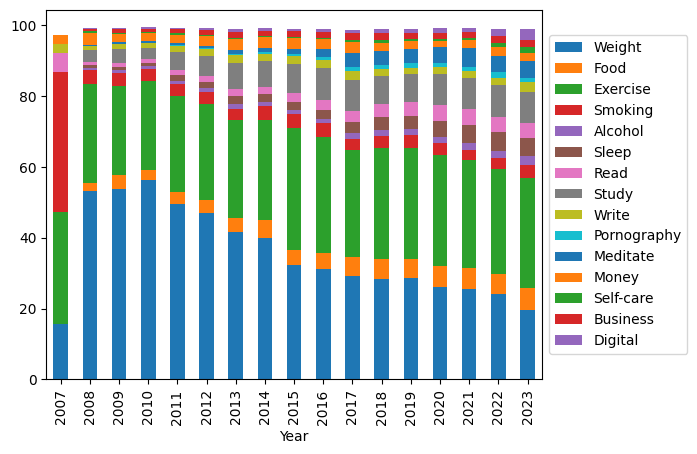

In [63]:
year_data.plot(x='Year', kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1.0, 0.95), loc='upper left')
plt.savefig("../figures/topic_year.pdf",bbox_inches='tight')

# Month wise

In [46]:
month_count = {k:{i:0 for i in range(1,13)} for k in count_dict.keys()}
total_month = {i:0 for i in range(1,13)}

In [47]:
for k,v in count_dict.items():
    for i in set(v):
        month_count[k][commitment_index[i]['start_date'].month]+=1
        total_month[commitment_index[i]['start_date'].month]+=1

In [48]:
for k,v in month_count.items():
    for m,c in v.items():
        month_count[k][m]=c*100/total_month[m]

In [49]:
month_data = pd.DataFrame.from_dict(month_count)

In [50]:
month_data['month'] = month_data.index

In [51]:
month_data

,weight,eat,exercise,smoking,alcohol,sleep,read,study,write,mastrubate,meditate,money,nail,client,procrastinating,clean,internet,month
1,37.382666,4.301687,30.698204,3.082949,1.433166,2.599392,3.111393,5.903332,1.711047,0.509813,3.078573,2.780999,0.503249,1.293132,0.385095,0.424480,0.800823,1
2,34.097639,5.102118,30.889834,3.390024,1.393212,3.500114,2.797813,6.996432,2.027181,0.770632,2.459950,2.254954,0.706097,1.636170,0.485916,0.504897,0.987017,2
3,35.080692,5.074859,30.332491,3.348240,1.345518,3.087692,2.512152,7.587011,1.722730,0.785534,2.313825,2.516041,0.536652,1.718841,0.443321,0.509430,1.084970,3
4,34.417950,4.988409,30.315450,3.278689,1.357841,2.926809,2.868852,8.043550,2.102997,0.794834,2.603908,2.297566,0.616824,1.469614,0.426395,0.521610,0.968703,4
5,34.835415,5.291618,29.131797,3.424746,1.334707,3.029913,2.926913,7.827990,2.218789,1.038582,2.416205,2.278872,0.648041,1.639415,0.407708,0.532166,1.017124,5
6,34.794363,4.790817,29.285588,3.354902,1.391597,2.925013,2.964900,7.884240,2.082964,0.943982,2.526148,2.960468,0.633753,1.560007,0.350115,0.607162,0.943982,6
7,34.612546,4.644834,29.368081,3.399446,1.526753,2.965867,3.071956,7.435424,2.181734,0.830258,3.044280,2.684502,0.581181,1.683579,0.539668,0.622694,0.807196,7
8,33.995585,4.866323,29.237184,3.311258,1.609026,3.301447,3.203336,7.696836,2.192789,0.927152,2.776551,2.511651,0.627913,1.648271,0.554329,0.593574,0.946775,8
9,33.036286,4.793895,30.481674,3.847912,1.448679,2.837949,2.787679,8.289919,2.006215,1.005393,2.422082,2.897359,0.580386,1.590348,0.388447,0.584956,1.000823,9
10,34.443033,4.834906,29.472061,3.669267,1.428701,3.247460,2.911829,8.132257,2.104499,0.938861,2.358491,2.467344,0.566945,1.396952,0.512518,0.526125,0.988752,10


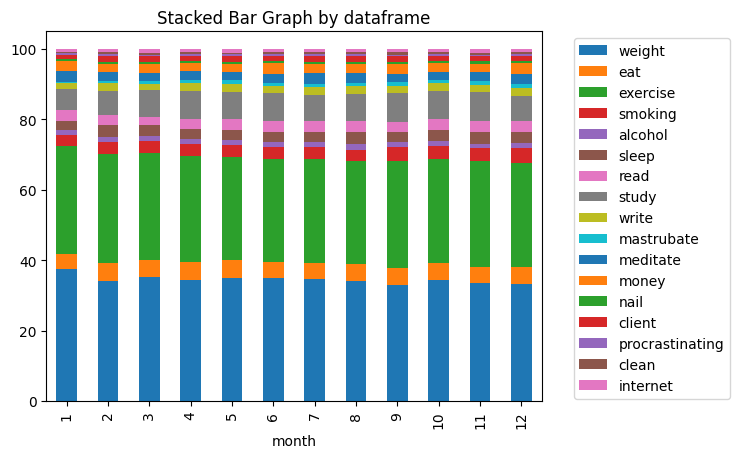

In [52]:
month_data.plot(x='month', kind='bar', stacked=True,
        title='Stacked Bar Graph by dataframe')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')